# Astrometric correction to the JWST and HST cutouts

For each target we have a series of HST cutouts and JWST cutouts. The cutouts in each dataset are aligned within themselves, but they are all offset from the refence F160W "astromcorr" mosaic that was used for the MSA configuration. Here, we measure the centroid of each source in the astromcorr mosaic and compare to the centroid measured in the cutouts, so we can derive an astrometric correction.

Result: while the HST cutouts are substantially offset, the JWST cutouts have an astrometric error of the order of 15 mas, so they are pretty much as good as it gets!

In [1]:
from astropy.io import fits
from astropy import table
import numpy as np
from matplotlib import pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from astropy.nddata import Cutout2D
from photutils import centroids
import scipy

In [2]:
# read in catalog from the MSA metafiles
cat_ref_N = table.Table.read('updated_msafiles/jw01810001001_01_bluejay_msa.fits',3)
cat_ref_S = table.Table.read('updated_msafiles/jw01810002001_01_bluejay_msa.fits',3)
cat_ref = table.vstack([cat_ref_N, cat_ref_S])

# discard background slits and empty slits
cat = cat_ref[ np.where( (cat_ref['source_id']>0) & (cat_ref['source_id']<30000) ) ]
0
# add columns to store the astrometric offset
cat['hst_dra'] = 0.0*u.arcsec
cat['hst_ddec'] = 0.0*u.arcsec
cat['jwst_dra'] = 0.0*u.arcsec
cat['jwst_ddec'] = 0.0*u.arcsec

cat

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity,hst_dra,hst_ddec,jwst_dra,jwst_ddec
,,,,,,,,arcsec,arcsec,arcsec,arcsec
int32,int32,bytes20,bytes31,float64,float64,bytes30,float64,float64,float64,float64,float64
1810,16419,1810_16419,16419,150.0956098784945,2.350068700469065,01810001_001,0.0,0.0,0.0,0.0,0.0
1810,16424,1810_16424,16424,150.1101583934326,2.346669586114658,01810001_001,0.0,0.0,0.0,0.0,0.0
1810,16474,1810_16474,16474,150.113438339162,2.347474586507182,01810001_001,0.0,0.0,0.0,0.0,0.0
1810,16516,1810_16516,16516,150.1153377347839,2.347698518052218,01810001_001,0.0,0.0,0.0,0.0,0.0
1810,16615,1810_16615,16615,150.1037259277942,2.348593014753147,01810001_001,0.0,0.0,0.0,0.0,0.0
1810,16874,1810_16874,16874,150.0982912365253,2.351571680486413,01810001_001,0.0,0.0,0.0,0.0,0.0
1810,17000,1810_17000,17000,150.1155512029518,2.353707000936673,01810001_001,0.0,0.0,0.0,0.0,0.0
1810,17517,1810_17517,17517,150.0944632461632,2.358221436691601,01810001_001,0.0,0.0,0.0,0.0,0.0


In [3]:
# open F160W mosaic
hdu_mosaic = fits.open('COSMOS_DASH_submosaic_astromcorr.fits')[0]

# Calculate offset for HST cutouts

In [4]:

for i,g in enumerate(cat):

    cutout_side = 2.5*u.arcsec
    good_frac_cutout = 0.7
    smooth_sigma = 1.0

    if g['source_id'] == 16424: # faint source, use bright source nearby
        cutout_side = 2.8*u.arcsec
        good_frac_cutout = 0.9
    if g['source_id'] == 7904: # exclude bright source nearby
        good_frac_cutout = 0.4
    if g['source_id'] == 11716: # exclude bright source nearby
        good_frac_cutout = 0.4
    if g['source_id'] == 21472: # fuzzy source, smooth more
        smooth_sigma=2.0
        
    print(g['source_id'])
    ref_position = SkyCoord(ra=g['ra'], dec=g['dec'], unit=u.deg)
    cutout_size = (cutout_side, cutout_side)

    # extract cutout from reference mosaic
    cutout_mosaic = Cutout2D(hdu_mosaic.data, ref_position, cutout_size, wcs=WCS(hdu_mosaic))

    # extract cutout from the F160W cutout
    hst_cutout_name = f"v1.0_HST_cutouts/{g['source_id']}_F160W_CutOut.fits"
    try:
        hdu_hst = fits.open(hst_cutout_name)[0]
    except:
        print("NO HST CUTOUT FOUND")
        continue
    cutout_hst = Cutout2D(hdu_hst.data, ref_position, cutout_size, wcs=WCS(hdu_hst))
    cutout_hst.wcs.wcs.radesys = 'ICRS' # change to ICRS, which is the frame of the reference mosaic
    
    # find centroid in mosaic
    fig, axs = plt.subplots(1,2, figsize=[10,5])
    cutout_mosaic_smooth = scipy.ndimage.gaussian_filter(cutout_mosaic.data, smooth_sigma)
    axs[0].imshow(cutout_mosaic_smooth)
    ref_pix = cutout_mosaic.wcs.world_to_pixel(ref_position)
    centroid_mosaic_pix = centroids.centroid_quadratic(
        cutout_mosaic_smooth, 
        xpeak=cutout_mosaic.data.shape[0]//2, ypeak=cutout_mosaic.data.shape[1]//2, 
        search_boxsize=int(np.floor(good_frac_cutout*cutout_mosaic_smooth.shape[0])//2*2+1), fit_boxsize=5)
    centroid_mosaic = cutout_mosaic.wcs.pixel_to_world(centroid_mosaic_pix[0], centroid_mosaic_pix[1])
    axs[0].plot(centroid_mosaic_pix[0], centroid_mosaic_pix[1], 'x', color='red')
    axs[0].set(title='Reference F160W image')
    
    # find centroid in HST cutout
    cutout_hst_smooth = scipy.ndimage.gaussian_filter(cutout_hst.data, 1.5*smooth_sigma)
    axs[1].imshow(cutout_hst_smooth)
    ref_pix = cutout_hst.wcs.world_to_pixel(ref_position)
    centroid_hst_pix = centroids.centroid_quadratic(
        cutout_hst_smooth, 
        xpeak=cutout_hst.data.shape[0]//2, ypeak=cutout_hst.data.shape[1]//2, 
        search_boxsize=int(np.floor(good_frac_cutout*cutout_hst_smooth.shape[0])//2*2+1), fit_boxsize=5)
    centroid_hst = cutout_hst.wcs.pixel_to_world(centroid_hst_pix[0], centroid_hst_pix[1])
    axs[1].plot(centroid_hst_pix[0], centroid_hst_pix[1], 'o', color='orange')
    axs[1].set(title='HST F160W cutout')

    # show expected position of the centroid
    expected_position_pix = cutout_hst.wcs.world_to_pixel(centroid_mosaic)
    axs[1].plot(expected_position_pix[0], expected_position_pix[1], 'x', color='red')

    # if the fit does not find a centroid
    if np.isnan(centroid_mosaic_pix).any() | np.isnan(centroid_hst_pix).any():
        print("CENTROID NOT FOUND!")
        break

    fig.savefig(f"image_alignment/{g['source_id']}_HST_alignment.pdf")
    plt.close()

    # calculate offset and store in the catalog
    dra, ddec = centroid_mosaic.spherical_offsets_to(centroid_hst)
    print(dra.to(u.arcsec), ddec.to(u.arcsec))
    cat['hst_dra'][i] = dra.to(u.arcsec).value
    cat['hst_ddec'][i] = ddec.to(u.arcsec).value


16419
0.0873849 arcsec -0.02202 arcsec
16424
0.114824 arcsec 0.0208923 arcsec
16474
0.119438 arcsec 0.0141136 arcsec
16516
0.124209 arcsec 0.0189749 arcsec
16615
0.096884 arcsec -0.0174476 arcsec
16874
0.100257 arcsec -0.0249069 arcsec
17000
0.113863 arcsec -0.0182457 arcsec
17517
0.139487 arcsec 0.0198347 arcsec
17534
0.103351 arcsec -0.0127496 arcsec
17555
0.105204 arcsec 0.000632995 arcsec
17669
0.0930578 arcsec -0.00702105 arcsec
17713
0.113794 arcsec -0.0194375 arcsec
17793
0.0891432 arcsec 0.0286803 arcsec
17842
0.111455 arcsec 0.00369507 arcsec
17906
0.105555 arcsec 0.002445 arcsec
17916
0.109476 arcsec 0.00189949 arcsec
17954
0.083827 arcsec 0.0201013 arcsec
17984
0.0624673 arcsec 0.013792 arcsec
18071
0.0826681 arcsec -0.00304618 arcsec
18094
0.0999786 arcsec -0.0197944 arcsec
18139
0.100042 arcsec 0.00300589 arcsec
18252
0.0856557 arcsec 0.0097348 arcsec
18327
0.113301 arcsec -0.0108113 arcsec
18332
0.119502 arcsec -0.00173428 arcsec
18651
0.0863294 arcsec 0.0340284 arcsec
18

In [5]:
cat

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity,hst_dra,hst_ddec,jwst_dra,jwst_ddec
,,,,,,,,arcsec,arcsec,arcsec,arcsec
int32,int32,bytes20,bytes31,float64,float64,bytes30,float64,float64,float64,float64,float64
1810,16419,1810_16419,16419,150.0956098784945,2.350068700469065,01810001_001,0.0,0.08738490166174673,-0.022020038224723378,0.0,0.0
1810,16424,1810_16424,16424,150.1101583934326,2.346669586114658,01810001_001,0.0,0.11482408501942154,0.02089231063942475,0.0,0.0
1810,16474,1810_16474,16474,150.113438339162,2.347474586507182,01810001_001,0.0,0.11943781018610908,0.01411361926228293,0.0,0.0
1810,16516,1810_16516,16516,150.1153377347839,2.347698518052218,01810001_001,0.0,0.12420890288704069,0.018974874040430433,0.0,0.0
1810,16615,1810_16615,16615,150.1037259277942,2.348593014753147,01810001_001,0.0,0.09688400806820265,-0.017447568995618192,0.0,0.0
1810,16874,1810_16874,16874,150.0982912365253,2.351571680486413,01810001_001,0.0,0.10025664785278547,-0.024906943298586913,0.0,0.0
1810,17000,1810_17000,17000,150.1155512029518,2.353707000936673,01810001_001,0.0,0.11386287364992383,-0.018245731173800614,0.0,0.0
1810,17517,1810_17517,17517,150.0944632461632,2.358221436691601,01810001_001,0.0,0.13948696458779722,0.019834653104475082,0.0,0.0


Text(0.5, 1.0, 'Astrometric offset from F160W cutout to reference mosaic')

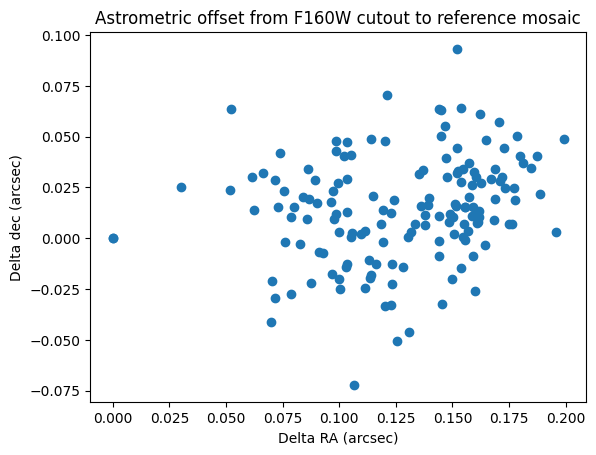

In [6]:
plt.scatter(cat['hst_dra'], cat['hst_ddec'])
plt.xlabel('Delta RA (arcsec)')
plt.ylabel('Delta dec (arcsec)')
plt.title('Astrometric offset from F160W cutout to reference mosaic')

[Text(0.5, 0, 'RA'),
 Text(0, 0.5, 'dec'),
 Text(0.5, 1.0, 'Astrometric offset from F160W cutout to reference mosaic')]

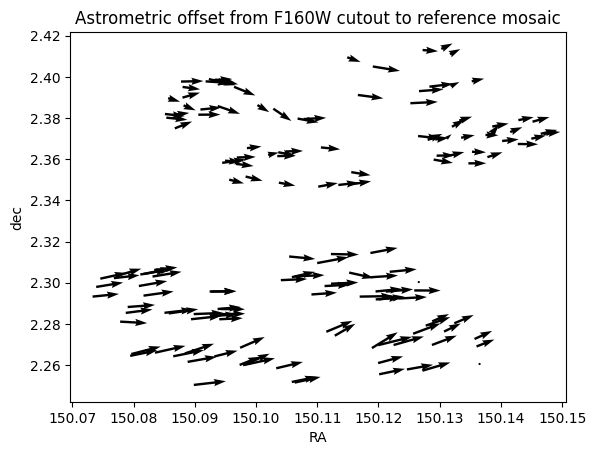

In [7]:
fig, ax = plt.subplots()
ax.quiver(cat['ra'], cat['dec'], cat['hst_dra'], cat['hst_ddec'])
ax.set(xlabel='RA', ylabel='dec', title='Astrometric offset from F160W cutout to reference mosaic')

# Calculate offset for JWST cutouts

In [38]:
import warnings

for i,g in enumerate(cat):

    cutout_side = 2.5*u.arcsec
    good_frac_cutout = 0.7
    smooth_sigma = 1.0

    if g['source_id'] == 16424: # faint source, use bright source nearby
        cutout_side = 2.8*u.arcsec
        good_frac_cutout = 0.9
    if g['source_id'] == 7904: # exclude bright source nearby
        good_frac_cutout = 0.4
    if g['source_id'] == 11716: # exclude bright source nearby
        good_frac_cutout = 0.4
    if g['source_id'] == 21472: # fuzzy source, smooth more
        smooth_sigma=2.0
    if g['source_id'] == 10054: # exclude bright source nearby
        good_frac_cutout = 0.4
        
    print(g['source_id'])
    ref_position = SkyCoord(ra=g['ra'], dec=g['dec'], unit=u.deg)
    cutout_size = (cutout_side, cutout_side)

    # extract cutout from reference mosaic
    cutout_mosaic = Cutout2D(hdu_mosaic.data, ref_position, cutout_size, wcs=WCS(hdu_mosaic))

    # extract cutout from the NIRCam F150W cutout
    jwst_cutout_name = f"v1.0_JWST_cutouts/{g['source_id']}_F150W_cutout.fits"
    try:
        hdu_jwst = fits.open(jwst_cutout_name)[1]
    except:
        print("NO JWST CUTOUT FOUND")
        continue

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cutout_jwst = Cutout2D(hdu_jwst.data, ref_position, cutout_size, wcs=WCS(hdu_jwst))
    
    # find centroid in mosaic
    fig, axs = plt.subplots(1,2, figsize=[10,5])
    cutout_mosaic_smooth = scipy.ndimage.gaussian_filter(cutout_mosaic.data, smooth_sigma)
    axs[0].imshow(cutout_mosaic_smooth)
    ref_pix = cutout_mosaic.wcs.world_to_pixel(ref_position)
    centroid_mosaic_pix = centroids.centroid_quadratic(
        cutout_mosaic_smooth, 
        xpeak=cutout_mosaic.data.shape[0]//2, ypeak=cutout_mosaic.data.shape[1]//2, 
        search_boxsize=int(np.floor(good_frac_cutout*cutout_mosaic_smooth.shape[0])//2*2+1), fit_boxsize=5)
    centroid_mosaic = cutout_mosaic.wcs.pixel_to_world(centroid_mosaic_pix[0], centroid_mosaic_pix[1])
    axs[0].plot(centroid_mosaic_pix[0], centroid_mosaic_pix[1], 'x', color='red')
    axs[0].set(title='Reference F160W image')
    
    # find centroid in JWST cutout
    cutout_jwst_smooth = scipy.ndimage.gaussian_filter(cutout_jwst.data, 5*smooth_sigma)
    axs[1].imshow(cutout_jwst_smooth)
    ref_pix = cutout_jwst.wcs.world_to_pixel(ref_position)
    centroid_jwst_pix = centroids.centroid_quadratic(
        cutout_jwst_smooth, 
        xpeak=cutout_jwst.data.shape[0]//2, ypeak=cutout_jwst.data.shape[1]//2, 
        search_boxsize=int(np.floor(good_frac_cutout*cutout_jwst_smooth.shape[0])//2*2+1), fit_boxsize=9)
    centroid_jwst = cutout_jwst.wcs.pixel_to_world(centroid_jwst_pix[0], centroid_jwst_pix[1])
    axs[1].plot(centroid_jwst_pix[0], centroid_jwst_pix[1], 'o', color='orange')
    axs[1].set(title='JWST F150W cutout')

    # show expected position of the centroid
    expected_position_pix = cutout_jwst.wcs.world_to_pixel(centroid_mosaic)
    axs[1].plot(expected_position_pix[0], expected_position_pix[1], 'x', color='red')

    # if the fit does not find a centroid
    if np.isnan(centroid_mosaic_pix).any() | np.isnan(centroid_hst_pix).any():
        print("CENTROID NOT FOUND!")
        break

    fig.savefig(f"image_alignment/{g['source_id']}_JWST_alignment.pdf")
    plt.close()

    # calculate offset and store in the catalog
    dra, ddec = centroid_mosaic.spherical_offsets_to(centroid_jwst)
    print(dra.to(u.arcsec), ddec.to(u.arcsec))
    cat['jwst_dra'][i] = dra.to(u.arcsec).value
    cat['jwst_ddec'][i] = ddec.to(u.arcsec).value


16419
-0.0025339 arcsec -0.00297645 arcsec
16424
-0.0177325 arcsec 0.0168605 arcsec
16474
-0.00620225 arcsec 0.0119573 arcsec
16516
-0.00578112 arcsec 0.0169192 arcsec
16615
0.0680215 arcsec 0.0290926 arcsec
16874
-0.000564158 arcsec 0.00449833 arcsec
17000
-0.00506654 arcsec -0.00112203 arcsec
17517
0.0200957 arcsec 0.0305131 arcsec
17534
-0.000827229 arcsec 0.0207271 arcsec
17555
0.0240399 arcsec -0.00200241 arcsec
17669
-0.0198715 arcsec 0.0155157 arcsec
17713
0.00265089 arcsec -0.00419816 arcsec
17793
0.000246209 arcsec 0.00664007 arcsec
17842
-0.00689035 arcsec 0.0148263 arcsec
17906
nan nan
17916
-0.00200199 arcsec 0.0229318 arcsec
17954
-0.0112462 arcsec -0.0148528 arcsec
17984


-0.0217153 arcsec 0.0342581 arcsec
18071
-0.00382035 arcsec -0.00875863 arcsec
18094
0.00212275 arcsec 0.00106734 arcsec
18139
-0.0158956 arcsec 0.0223721 arcsec
18252
-0.00542076 arcsec 0.0184053 arcsec
18327
-0.00700851 arcsec 0.0305234 arcsec
18332
0.0114573 arcsec -0.0231187 arcsec
18651
0.0650002 arcsec -0.0379369 arcsec
18653
-0.0332694 arcsec 0.0608615 arcsec
18668
0.00706847 arcsec -0.000598823 arcsec
18688
-0.00642021 arcsec -0.00342957 arcsec
18733
-0.025491 arcsec -0.00669081 arcsec
18769
0.0146592 arcsec 0.0140496 arcsec
18839
-0.0133108 arcsec -0.00425705 arcsec
18943
0.021377 arcsec 0.00856546 arcsec
18968
-0.000799032 arcsec -0.0198511 arcsec
18977
0.00112928 arcsec 0.0118301 arcsec
19024
-0.0167634 arcsec 0.00670023 arcsec
19098
-0.0237801 arcsec 0.0257351 arcsec
19307
0.00986067 arcsec 0.0420829 arcsec
19342
0.00291806 arcsec 0.0131519 arcsec
19393
-0.0141011 arcsec -0.00511421 arcsec
19563
0.00950374 arcsec 0.0132407 arcsec
19572
-0.00552596 arcsec 0.00305226 arcsec
1

0.065714 arcsec 0.0415703 arcsec
20332
0.0466554 arcsec -0.013432 arcsec
20388
0.0180628 arcsec -0.0345292 arcsec
20397
0.1004 arcsec 0.0236463 arcsec
20472
0.0120868 arcsec -0.00215552 arcsec
20693
-0.162193 arcsec -0.0458851 arcsec
20720
0.0263243 arcsec 0.00284867 arcsec
20852
0.00475067 arcsec 0.015935 arcsec
21026
0.0046576 arcsec 0.014615 arcsec
21165
-0.0378618 arcsec -0.0218144 arcsec
21178
0.0131775 arcsec 0.0200813 arcsec
21213
-0.00939501 arcsec 0.00768154 arcsec
21218
0.0427778 arcsec 0.00829483 arcsec
21424
0.00555403 arcsec 0.00939882 arcsec
21451
0.0281252 arcsec 0.0179425 arcsec
21452
0.00771127 arcsec 0.00853868 arcsec
21472
0.0352305 arcsec 0.00404689 arcsec
21477
0.0138401 arcsec 0.00891149 arcsec
21541
0.0101081 arcsec 0.00488013 arcsec
21547
0.00607801 arcsec 0.0145927 arcsec
22199
-0.0373176 arcsec 0.045818 arcsec
22606


nan nan
22758
0.0058433 arcsec 0.0467023 arcsec
22940
0.0030809 arcsec -7.7083e-05 arcsec
22990
0.0212499 arcsec 0.0102374 arcsec
7102
0.0340455 arcsec 0.0232118 arcsec
7136
0.000685393 arcsec 0.00241621 arcsec
7185
0.0143763 arcsec 0.0133831 arcsec
7549
0.00287153 arcsec -0.00154789 arcsec
7696
0.0712645 arcsec 0.0177744 arcsec
7730
-0.00865081 arcsec 0.0123166 arcsec
7735
0.00841091 arcsec -0.0161098 arcsec
7904
0.0527935 arcsec -0.0681825 arcsec
7922
-0.00699118 arcsec 0.0243419 arcsec
7934
-0.0206669 arcsec 0.022251 arcsec
8002
-0.00173977 arcsec 0.0158911 arcsec
8013
0.0075263 arcsec 0.00345416 arcsec
8280
-0.00342469 arcsec 0.00474858 arcsec
8323
-0.0147798 arcsec -2.19416e-05 arcsec
8338
-0.0126425 arcsec -0.0154679 arcsec
8465
0.0212177 arcsec 0.0151645 arcsec
8469
-0.00360998 arcsec -0.73377 arcsec
8500
-0.000607899 arcsec 0.0166021 arcsec
8700
0.00322276 arcsec 0.0163941 arcsec
8741
0.0199072 arcsec 0.0447218 arcsec
8843
-0.0211626 arcsec 0.016676 arcsec
8850
0.00948413 arcse

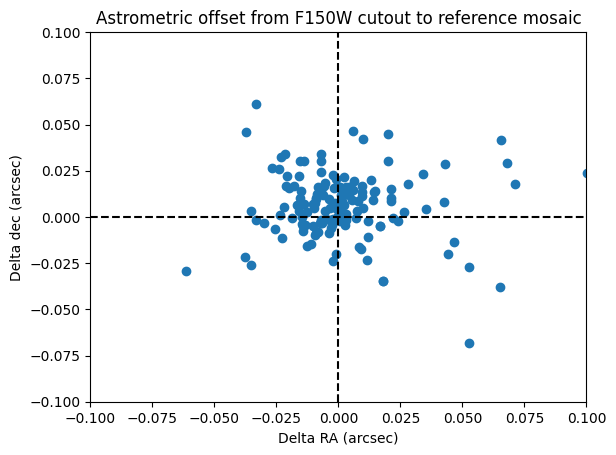

In [39]:
plt.scatter(cat['jwst_dra'], cat['jwst_ddec'])
plt.xlabel('Delta RA (arcsec)')
plt.ylabel('Delta dec (arcsec)')
plt.title('Astrometric offset from F150W cutout to reference mosaic')
plt.xlim(-0.1, 0.1)
plt.ylim(-0.1, 0.1)
plt.axvline(0, ls='--', color='k')
plt.axhline(0, ls='--', color='k')


In [49]:
w_outliers = np.where( np.abs(cat['jwst_dra']**2 + cat['jwst_ddec']**2) > 0.05**2)
w_ok = np.where( np.abs(cat['jwst_dra']**2 + cat['jwst_ddec']**2) <= 0.05**2)
cat[w_outliers]

program,source_id,source_name,alias,ra,dec,preimage_id,stellarity,hst_dra,hst_ddec,jwst_dra,jwst_ddec
,,,,,,,,arcsec,arcsec,arcsec,arcsec
int32,int32,bytes20,bytes31,float64,float64,bytes30,float64,float64,float64,float64,float64
1810,16615,1810_16615,16615,150.1037259277942,2.348593014753147,01810001_001,0.0,0.09688400806820265,-0.017447568995618192,0.06802152501341303,0.029092550614306465
1810,18651,1810_18651,18651,150.1280348311198,2.369448443018312,01810001_001,0.0,0.08632944685805337,0.03402841757761116,0.06500018355282446,-0.037936912542976
1810,18653,1810_18653,18653,150.1401912,2.3688509,01810001_001,0.0,0.09752537865747922,0.009568020786597202,-0.03326940415997681,0.06086147306802129
1810,19891,1810_19891,19891,150.0862249745954,2.381411890292121,01810001_001,0.0,0.10346672984087081,0.012708753648829304,-0.06159724945561147,-0.029319098413075194
1810,19952,1810_19952,19952,150.0851140498617,2.381944098977842,01810001_001,0.0,0.11607134560777418,-0.012850310224731454,-0.09009340585779024,0.15055628384408123
1810,20238,1810_20238,20238,150.1028214164274,2.384507092141293,01810001_001,0.0,0.10638960234578163,-0.07213862931469615,0.0657139528381508,0.041570282719042305
1810,20397,1810_20397,20397,150.100225763686,2.386264742307609,01810001_001,0.0,0.0697112996592493,-0.04139513624941783,0.10039968157718274,0.023646281319596115
1810,20693,1810_20693,20693,150.0856344780626,2.389624999864423,01810001_001,0.0,0.07031459316553834,-0.020960098212276443,-0.1621928272895552,-0.04588514876837694


0.015748215714288208


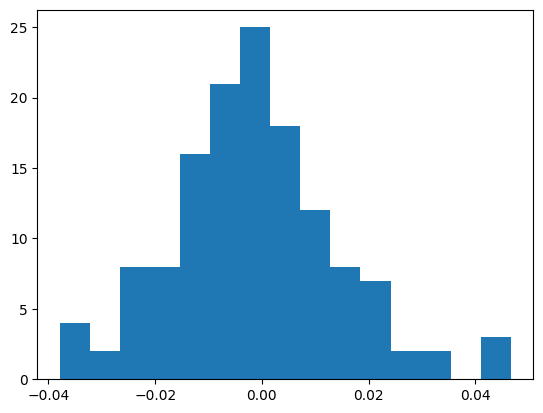

In [56]:
plt.hist(cat['jwst_dra'][w_ok], bins=15)

(array([ 2.,  2.,  4.,  5.,  7., 17., 24., 19., 17., 19.,  8.,  4.,  5.,
         0.,  3.]),
 array([-0.034797  , -0.02936372, -0.02393043, -0.01849714, -0.01306386,
        -0.00763057, -0.00219728,  0.003236  ,  0.00866929,  0.01410258,
         0.01953586,  0.02496915,  0.03040244,  0.03583572,  0.04126901,
         0.0467023 ]),
 <BarContainer object of 15 artists>)

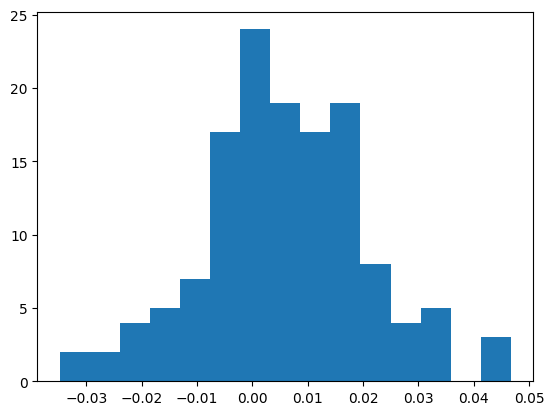

In [51]:
plt.hist(cat['jwst_ddec'][w_ok], bins=15)

In [62]:
print(f"standard deviation: {np.nanstd(cat['jwst_dra'][w_ok]):.4f} arcsec in RA; \
    {np.nanstd(cat['jwst_ddec'][w_ok]):.4f} arcsec in dec")

standard deviation: 0.0157 arcsec in RA;     0.0147 arcsec in dec


[Text(0.5, 0, 'RA'),
 Text(0, 0.5, 'dec'),
 Text(0.5, 1.0, 'Astrometric offset from F150W cutout to reference mosaic')]

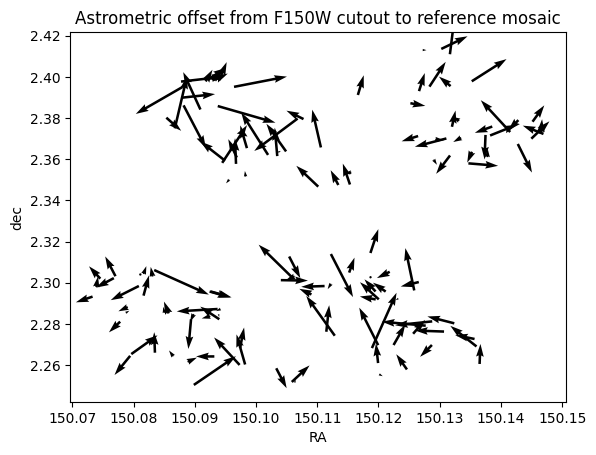

In [52]:
fig, ax = plt.subplots()
ax.quiver(cat['ra'][w_ok], cat['dec'][w_ok], cat['jwst_dra'][w_ok], cat['jwst_ddec'][w_ok])
ax.set(xlabel='RA', ylabel='dec', title='Astrometric offset from F150W cutout to reference mosaic')

In [ ]:

    # # update the WCS of the HST cutout
    # hst_wcs = WCS(hdu_hst)
    # old_crval = SkyCoord(hst_wcs.wcs.crval[0], hst_wcs.wcs.crval[1], unit=u.deg)
    # new_crval = old_crval.spherical_offsets_by(dx*u.arcsec, dy*u.arcsec)
    # hst_wcs.wcs.crval = [new_crval.ra.to(u.deg).value, new_crval.dec.to(u.deg).value]
    # hdu_hst.header.update(hst_wcs.to_header())
    
    # # make a new HST cutout
    # newhst_cutout_name = f"v1.2_HST_cutouts/{g['source_id']}_F160W_CutOut_v1.2.fits"
    # hdu_hst.writeto(newhst_cutout_name, overwrite=True)
